In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2023-12-11 10:46:57.737594: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 10:46:58.494535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [2]:
eric_dir = '/home/emarkley/Workspace/PYTHON/InformationTheoryEndToEnd/MIMeasurements/'
folder = 'BigObjectSmallPSF_xlr0.003_ylr0.003_rlr0.005_unetlr0.0001'
filenames = [file for file in os.listdir(eric_dir + folder) if file.endswith('.npy')]
indices = [int(file.split('_')[-1].split('.')[0]) for file in filenames]
# sort by index
filenames = [x for _,x in sorted(zip(indices,filenames))]

# load data for each
data = []
for file in filenames:
    data.append(np.load(eric_dir + folder + '/' + file))
print(filenames)

['mi_measurements_0.npy', 'mi_measurements_1.npy', 'mi_measurements_2.npy', 'mi_measurements_3.npy', 'mi_measurements_4.npy', 'mi_measurements_5.npy', 'mi_measurements_6.npy', 'mi_measurements_7.npy', 'mi_measurements_8.npy', 'mi_measurements_9.npy', 'mi_measurements_10.npy', 'mi_measurements_11.npy', 'mi_measurements_12.npy', 'mi_measurements_13.npy', 'mi_measurements_14.npy', 'mi_measurements_15.npy', 'mi_measurements_16.npy', 'mi_measurements_17.npy', 'mi_measurements_18.npy', 'mi_measurements_19.npy', 'mi_measurements_20.npy']


In [3]:
data[0].shape

(2000, 100, 100)

(2000, 100, 100)
98.82459678785874 98.9188598678444


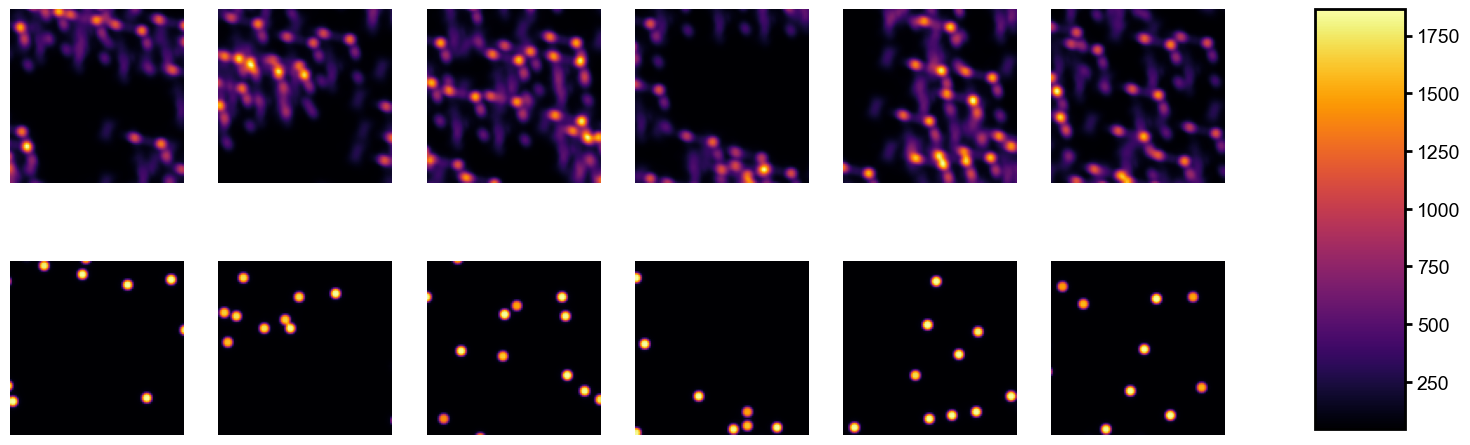

In [3]:
num_plots = 6

initial_clean_data = data[0]
final_clean_data = data[-1]

# find shared vmin and vmax from both datasets
vmin = np.min(np.concatenate([initial_clean_data, final_clean_data]))
vmax = np.max(np.concatenate([initial_clean_data, final_clean_data]))


fig, axes = plt.subplots(2, num_plots, figsize=(3 * num_plots,6))
for i, ax in enumerate(axes.T):
    ax[0].imshow(initial_clean_data[i], cmap='inferno')
    ax[0].axis('off')
    im = ax[1].imshow(final_clean_data[i], cmap='inferno')
    ax[1].axis('off')

# show shared colorbar on right side
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

print (initial_clean_data.shape)
print(initial_clean_data.mean(), final_clean_data.mean())

Text(0.5, 1.0, 'Noisy Data')

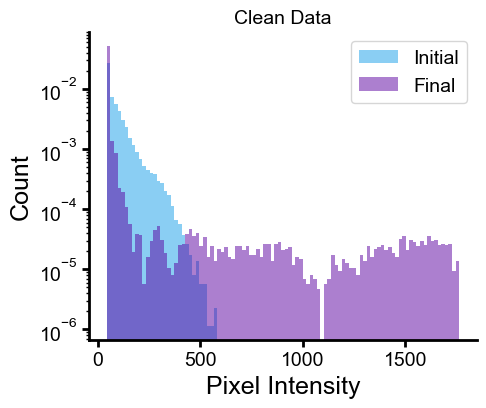

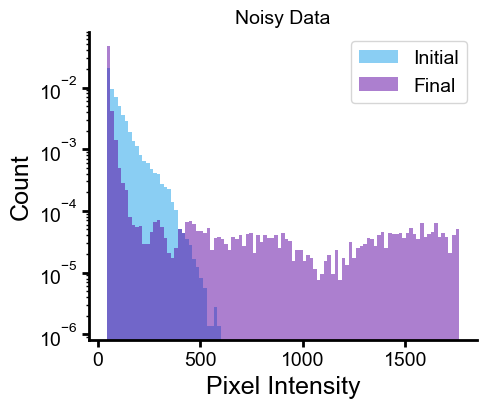

In [4]:
# plot histogram of clean patches
fig, ax = plt.subplots(1, 1, figsize=(5,4))
bins = np.linspace(min(initial_clean_data[:5].min(), final_clean_data[:5].min()),
                        max(np.percentile(initial_clean_data[:5], 99.5), np.percentile(final_clean_data[:5], 99.5)), 100)


ax.hist(initial_clean_data[:5].flatten(),  alpha=0.5, label='Initial', bins=bins, density=True, log=True)
ax.hist(final_clean_data[:5].flatten(),  alpha=0.5, label='Final', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
clear_spines(ax)
ax.set_title('Clean Data')


# plot histogram of noisy patches
fig, ax = plt.subplots(1, 1, figsize=(5,4))
initial_noisy_data_to_show = add_noise(data[0][:5])
final_noisy_data_to_show = add_noise(data[-1][:5])
ax.hist(initial_noisy_data_to_show.flatten(),  alpha=0.5, label='Initial', bins=bins, density=True, log=True)
ax.hist(final_noisy_data_to_show.flatten(),  alpha=0.5, label='Final', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
clear_spines(ax)
ax.set_title('Noisy Data')


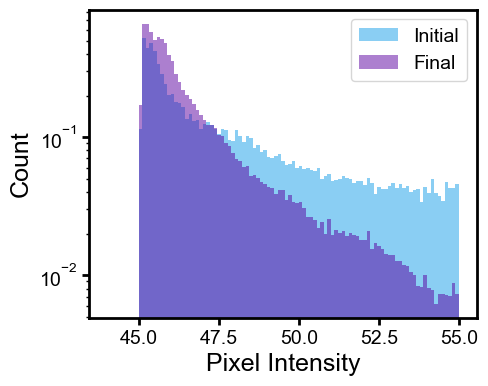

In [5]:
small_data_threshold = initial_clean_data.min() + 10
num_images = 10

small_val_clean_data_initial = initial_clean_data[:num_images]
small_val_clean_data_initial = small_val_clean_data_initial[small_val_clean_data_initial < small_data_threshold]

small_val_clean_data_final = final_clean_data[:num_images]
small_val_clean_data_final = small_val_clean_data_final[small_val_clean_data_final < small_data_threshold]

bins = np.linspace(initial_clean_data.min()-1, small_data_threshold, 100)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(small_val_clean_data_initial.flatten(),  alpha=0.5, label='Initial', bins=bins, density=True, log=True)
ax.hist(small_val_clean_data_final.flatten(),  alpha=0.5, label='Final', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()


## Look at MI estimates vs patch size for inital and final time points

In [6]:
patch_size_list = [30]
num_patches = 5000

mi_estimates_initial = []
mi_estimates_final = []
pixel_cnns_initial = []
pixel_cnns_final = []
for patch_size in tqdm(patch_size_list):
    clean_patches_initial = extract_patches(initial_clean_data, patch_size, num_patches)
    noisy_patches_initial = add_noise(clean_patches_initial)
    mi, pixel_cnn = estimate_mutual_information(noisy_patches_initial, clean_images=clean_patches_initial,
                                                entropy_model='pixel_cnn',    
                                                do_lr_decay=True, max_epochs=500, patience=200,                                            
                                                return_entropy_model=True, verbose=True)

   
    mi_estimates_initial.append(mi)
    pixel_cnns_initial.append(pixel_cnn)

    clean_patches_final = extract_patches(final_clean_data, patch_size, num_patches)
    noisy_patches_final = add_noise(clean_patches_final)
    mi, pixel_cnn = estimate_mutual_information(noisy_patches_final, clean_images=clean_patches_final, 
                                                        do_lr_decay=True, max_epochs=500, patience=200,
                                                entropy_model='pixel_cnn', return_entropy_model=True, verbose=True)
    mi_estimates_final.append(mi)
    pixel_cnns_final.append(pixel_cnn)

  0%|          | 0/1 [00:00<?, ?it/s]

2023-12-11 10:48:37.560537: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 19.13


Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Epoch 1: validation NLL: 3.90


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


Epoch 2: validation NLL: 3.88


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 3: validation NLL: 3.85


Epoch 4: 100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


Epoch 4: validation NLL: 3.82


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 5: validation NLL: 3.82


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.32it/s]


Epoch 6: validation NLL: 3.87


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


Epoch 7: validation NLL: 3.80


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 8: validation NLL: 3.80


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Epoch 9: validation NLL: 3.79


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 10: validation NLL: 3.79


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.08it/s]


Epoch 11: validation NLL: 3.80


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


Epoch 12: validation NLL: 3.79


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 13: validation NLL: 3.79


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Epoch 14: validation NLL: 3.78


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 22.58it/s]


Epoch 15: validation NLL: 3.79


Epoch 16: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Epoch 16: validation NLL: 3.77


Epoch 17: 100%|██████████| 100/100 [00:05<00:00, 19.74it/s]


Epoch 17: validation NLL: 3.78


Epoch 18: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


Epoch 18: validation NLL: 3.78


Epoch 19: 100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


Epoch 19: validation NLL: 3.77


Epoch 20: 100%|██████████| 100/100 [00:05<00:00, 17.24it/s]


Epoch 20: validation NLL: 3.77


Epoch 21: 100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


Epoch 21: validation NLL: 3.78


Epoch 22: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


Epoch 22: validation NLL: 3.77


Epoch 23: 100%|██████████| 100/100 [00:06<00:00, 16.05it/s]


Epoch 23: validation NLL: 3.78


Epoch 24: 100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


Epoch 24: validation NLL: 3.77


Epoch 25: 100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


Epoch 25: validation NLL: 3.78


Epoch 26: 100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


Epoch 26: validation NLL: 3.77


Epoch 27: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 27: validation NLL: 3.78


Epoch 28: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]


Epoch 28: validation NLL: 3.78


Epoch 29: 100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


Epoch 29: validation NLL: 3.78


Epoch 30: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Epoch 30: validation NLL: 3.79


Epoch 31: 100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


Epoch 31: validation NLL: 3.79


Epoch 32: 100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


Epoch 32: validation NLL: 3.79


Epoch 33: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


Epoch 33: validation NLL: 3.78


Epoch 34: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Epoch 34: validation NLL: 3.78


Epoch 35: 100%|██████████| 100/100 [00:05<00:00, 16.79it/s]


Epoch 35: validation NLL: 3.79


Epoch 36: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


Epoch 36: validation NLL: 3.78


Epoch 37: 100%|██████████| 100/100 [00:05<00:00, 16.67it/s]


Epoch 37: validation NLL: 3.79


Epoch 38: 100%|██████████| 100/100 [00:05<00:00, 17.24it/s]


Epoch 38: validation NLL: 3.79


Epoch 39: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Epoch 39: validation NLL: 3.78


Epoch 40: 100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


Epoch 40: validation NLL: 3.79


Epoch 41: 100%|██████████| 100/100 [00:06<00:00, 16.61it/s]


Epoch 41: validation NLL: 3.79


Epoch 42: 100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


Epoch 42: validation NLL: 3.79


Epoch 43: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


Epoch 43: validation NLL: 3.79


Epoch 44: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Epoch 44: validation NLL: 3.79


Epoch 45: 100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


Epoch 45: validation NLL: 3.79


Epoch 46: 100%|██████████| 100/100 [00:06<00:00, 16.46it/s]


Epoch 46: validation NLL: 3.79


Epoch 47: 100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Epoch 47: validation NLL: 3.80


Epoch 48: 100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


Epoch 48: validation NLL: 3.80


Epoch 49: 100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


Epoch 49: validation NLL: 3.80


Epoch 50: 100%|██████████| 100/100 [00:05<00:00, 17.32it/s]


Epoch 50: validation NLL: 3.80


Epoch 51: 100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


Epoch 51: validation NLL: 3.80


Epoch 52: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 52: validation NLL: 3.80


Epoch 53: 100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


Epoch 53: validation NLL: 3.81


Epoch 54: 100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Epoch 54: validation NLL: 3.80


Epoch 55: 100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


Epoch 55: validation NLL: 3.81


Epoch 56: 100%|██████████| 100/100 [00:06<00:00, 16.31it/s]


Epoch 56: validation NLL: 3.80


Epoch 57: 100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


Epoch 57: validation NLL: 3.81


Epoch 58: 100%|██████████| 100/100 [00:06<00:00, 16.35it/s]


Epoch 58: validation NLL: 3.80


Epoch 59: 100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


Epoch 59: validation NLL: 3.81


Epoch 60: 100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


Epoch 60: validation NLL: 3.82


Epoch 61: 100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


Epoch 61: validation NLL: 3.81


Epoch 62: 100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


Epoch 62: validation NLL: 3.81


Epoch 63: 100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


Epoch 63: validation NLL: 3.81


Epoch 64: 100%|██████████| 100/100 [00:06<00:00, 16.28it/s]


Epoch 64: validation NLL: 3.81


Epoch 65: 100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


Epoch 65: validation NLL: 3.81


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 21.06it/s]


Epoch 66: validation NLL: 3.81


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 22.05it/s]


Epoch 67: validation NLL: 3.81


Epoch 68: 100%|██████████| 100/100 [00:05<00:00, 19.56it/s]


Epoch 68: validation NLL: 3.81


Epoch 69: 100%|██████████| 100/100 [00:05<00:00, 19.24it/s]


Epoch 69: validation NLL: 3.82


Epoch 70: 100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


Epoch 70: validation NLL: 3.82


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 20.39it/s]


Epoch 71: validation NLL: 3.81


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


Epoch 72: validation NLL: 3.82


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 20.08it/s]


Epoch 73: validation NLL: 3.82


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


Epoch 74: validation NLL: 3.82


Epoch 75: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Epoch 75: validation NLL: 3.82


Epoch 76: 100%|██████████| 100/100 [00:05<00:00, 19.13it/s]


Epoch 76: validation NLL: 3.82


Epoch 77: 100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


Epoch 77: validation NLL: 3.82


Epoch 78: 100%|██████████| 100/100 [00:05<00:00, 19.57it/s]


Epoch 78: validation NLL: 3.82


Epoch 79: 100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


Epoch 79: validation NLL: 3.82


Epoch 80: 100%|██████████| 100/100 [00:05<00:00, 19.41it/s]


Epoch 80: validation NLL: 3.83


Epoch 81: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Epoch 81: validation NLL: 3.83


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 20.03it/s]


Epoch 82: validation NLL: 3.83


Epoch 83: 100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


Epoch 83: validation NLL: 3.83


Epoch 84: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


Epoch 84: validation NLL: 3.83


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


Epoch 85: validation NLL: 3.84


Epoch 86: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


Epoch 86: validation NLL: 3.84


Epoch 87: 100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


Epoch 87: validation NLL: 3.83


Epoch 88: 100%|██████████| 100/100 [00:05<00:00, 19.55it/s]


Epoch 88: validation NLL: 3.84


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


Epoch 89: validation NLL: 3.84


Epoch 90: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Epoch 90: validation NLL: 3.84


Epoch 91: 100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


Epoch 91: validation NLL: 3.84


Epoch 92: 100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


Epoch 92: validation NLL: 3.85


Epoch 93: 100%|██████████| 100/100 [00:05<00:00, 18.89it/s]


Epoch 93: validation NLL: 3.85


Epoch 94: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


Epoch 94: validation NLL: 3.84


Epoch 95: 100%|██████████| 100/100 [00:05<00:00, 18.96it/s]


Epoch 95: validation NLL: 3.85


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]


Epoch 96: validation NLL: 3.85


Epoch 97: 100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


Epoch 97: validation NLL: 3.85


Epoch 98: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]


Epoch 98: validation NLL: 3.85


Epoch 99: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Epoch 99: validation NLL: 3.86


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 20.75it/s]


Epoch 100: validation NLL: 3.86


Epoch 101: 100%|██████████| 100/100 [00:05<00:00, 19.53it/s]


Epoch 101: validation NLL: 3.86


Epoch 102: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


Epoch 102: validation NLL: 3.86


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


Epoch 103: validation NLL: 3.86


Epoch 104: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s]


Epoch 104: validation NLL: 3.86


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 20.02it/s]


Epoch 105: validation NLL: 3.87


Epoch 106: 100%|██████████| 100/100 [00:05<00:00, 19.25it/s]


Epoch 106: validation NLL: 3.87


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Epoch 107: validation NLL: 3.87


Epoch 108: 100%|██████████| 100/100 [00:05<00:00, 18.94it/s]


Epoch 108: validation NLL: 3.87


Epoch 109: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Epoch 109: validation NLL: 3.88


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 20.21it/s]


Epoch 110: validation NLL: 3.88


Epoch 111: 100%|██████████| 100/100 [00:05<00:00, 19.95it/s]


Epoch 111: validation NLL: 3.88


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 20.19it/s]


Epoch 112: validation NLL: 3.88


Epoch 113: 100%|██████████| 100/100 [00:05<00:00, 19.79it/s]


Epoch 113: validation NLL: 3.88


Epoch 114: 100%|██████████| 100/100 [00:05<00:00, 19.77it/s]


Epoch 114: validation NLL: 3.88


Epoch 115: 100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


Epoch 115: validation NLL: 3.89


Epoch 116: 100%|██████████| 100/100 [00:05<00:00, 19.88it/s]


Epoch 116: validation NLL: 3.89


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


Epoch 117: validation NLL: 3.89


Epoch 118: 100%|██████████| 100/100 [00:05<00:00, 19.87it/s]


Epoch 118: validation NLL: 3.89


Epoch 119: 100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


Epoch 119: validation NLL: 3.90


Epoch 120: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


Epoch 120: validation NLL: 3.90


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


Epoch 121: validation NLL: 3.89


Epoch 122: 100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


Epoch 122: validation NLL: 3.90


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


Epoch 123: validation NLL: 3.91


Epoch 124: 100%|██████████| 100/100 [00:05<00:00, 19.28it/s]


Epoch 124: validation NLL: 3.90


Epoch 125: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 125: validation NLL: 3.90


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


Epoch 126: validation NLL: 3.91


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 20.42it/s]


Epoch 127: validation NLL: 3.92


Epoch 128: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


Epoch 128: validation NLL: 3.92


Epoch 129: 100%|██████████| 100/100 [00:05<00:00, 18.75it/s]


Epoch 129: validation NLL: 3.92


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


Epoch 130: validation NLL: 3.92


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


Epoch 131: validation NLL: 3.93


Epoch 132: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


Epoch 132: validation NLL: 3.92


Epoch 133: 100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


Epoch 133: validation NLL: 3.92


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 20.41it/s]


Epoch 134: validation NLL: 3.93


Epoch 135: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


Epoch 135: validation NLL: 3.93


Epoch 136: 100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


Epoch 136: validation NLL: 3.93


Epoch 137: 100%|██████████| 100/100 [00:05<00:00, 19.85it/s]


Epoch 137: validation NLL: 3.93


Epoch 138: 100%|██████████| 100/100 [00:05<00:00, 19.33it/s]


Epoch 138: validation NLL: 3.94


Epoch 139: 100%|██████████| 100/100 [00:04<00:00, 20.53it/s]


Epoch 139: validation NLL: 3.94


Epoch 140: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


Epoch 140: validation NLL: 3.94


Epoch 141: 100%|██████████| 100/100 [00:05<00:00, 19.20it/s]


Epoch 141: validation NLL: 3.94


Epoch 142: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


Epoch 142: validation NLL: 3.94


Epoch 143: 100%|██████████| 100/100 [00:04<00:00, 20.25it/s]


Epoch 143: validation NLL: 3.96


Epoch 144: 100%|██████████| 100/100 [00:04<00:00, 20.36it/s]


Epoch 144: validation NLL: 3.94


Epoch 145: 100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


Epoch 145: validation NLL: 3.95


Epoch 146: 100%|██████████| 100/100 [00:05<00:00, 18.85it/s]


Epoch 146: validation NLL: 3.96


Epoch 147: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


Epoch 147: validation NLL: 3.96


Epoch 148: 100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


Epoch 148: validation NLL: 3.96


Epoch 149: 100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


Epoch 149: validation NLL: 3.97


Epoch 150: 100%|██████████| 100/100 [00:05<00:00, 19.01it/s]


Epoch 150: validation NLL: 3.96


Epoch 151: 100%|██████████| 100/100 [00:05<00:00, 19.43it/s]


Epoch 151: validation NLL: 3.96


Epoch 152: 100%|██████████| 100/100 [00:04<00:00, 20.79it/s]


Epoch 152: validation NLL: 3.98


Epoch 153: 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


Epoch 153: validation NLL: 3.97


Epoch 154: 100%|██████████| 100/100 [00:05<00:00, 19.25it/s]


Epoch 154: validation NLL: 3.98


Epoch 155: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


Epoch 155: validation NLL: 3.99


Epoch 156: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


Epoch 156: validation NLL: 3.98


Epoch 157: 100%|██████████| 100/100 [00:05<00:00, 19.62it/s]


Epoch 157: validation NLL: 3.98


Epoch 158: 100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


Epoch 158: validation NLL: 3.98


Epoch 159: 100%|██████████| 100/100 [00:05<00:00, 19.46it/s]


Epoch 159: validation NLL: 3.99


Epoch 160: 100%|██████████| 100/100 [00:05<00:00, 18.74it/s]


Epoch 160: validation NLL: 4.00


Epoch 161: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


Epoch 161: validation NLL: 3.99


Epoch 162: 100%|██████████| 100/100 [00:05<00:00, 19.88it/s]


Epoch 162: validation NLL: 3.99


Epoch 163: 100%|██████████| 100/100 [00:05<00:00, 19.27it/s]


Epoch 163: validation NLL: 4.00


Epoch 164: 100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


Epoch 164: validation NLL: 4.00


Epoch 165: 100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


Epoch 165: validation NLL: 4.01


Epoch 166: 100%|██████████| 100/100 [00:05<00:00, 18.98it/s]


Epoch 166: validation NLL: 4.01


Epoch 167: 100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


Epoch 167: validation NLL: 4.01


Epoch 168: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


Epoch 168: validation NLL: 4.01


Epoch 169: 100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


Epoch 169: validation NLL: 4.02


Epoch 170: 100%|██████████| 100/100 [00:04<00:00, 20.05it/s]


Epoch 170: validation NLL: 4.01


Epoch 171: 100%|██████████| 100/100 [00:05<00:00, 19.85it/s]


Epoch 171: validation NLL: 4.02


Epoch 172: 100%|██████████| 100/100 [00:05<00:00, 19.18it/s]


Epoch 172: validation NLL: 4.03


Epoch 173: 100%|██████████| 100/100 [00:05<00:00, 19.07it/s]


Epoch 173: validation NLL: 4.02


Epoch 174: 100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


Epoch 174: validation NLL: 4.03


Epoch 175: 100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


Epoch 175: validation NLL: 4.04


Epoch 176: 100%|██████████| 100/100 [00:05<00:00, 19.23it/s]


Epoch 176: validation NLL: 4.03


Epoch 177: 100%|██████████| 100/100 [00:05<00:00, 19.65it/s]


Epoch 177: validation NLL: 4.04


Epoch 178: 100%|██████████| 100/100 [00:04<00:00, 20.06it/s]


Epoch 178: validation NLL: 4.04


Epoch 179: 100%|██████████| 100/100 [00:05<00:00, 19.50it/s]


Epoch 179: validation NLL: 4.04


Epoch 180: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


Epoch 180: validation NLL: 4.05


Epoch 181: 100%|██████████| 100/100 [00:05<00:00, 19.91it/s]


Epoch 181: validation NLL: 4.05


Epoch 182: 100%|██████████| 100/100 [00:05<00:00, 19.63it/s]


Epoch 182: validation NLL: 4.04


Epoch 183: 100%|██████████| 100/100 [00:05<00:00, 19.26it/s]


Epoch 183: validation NLL: 4.04


Epoch 184: 100%|██████████| 100/100 [00:04<00:00, 20.41it/s]


Epoch 184: validation NLL: 4.05


Epoch 185: 100%|██████████| 100/100 [00:05<00:00, 19.73it/s]


Epoch 185: validation NLL: 4.06


Epoch 186: 100%|██████████| 100/100 [00:04<00:00, 20.50it/s]


Epoch 186: validation NLL: 4.06


Epoch 187: 100%|██████████| 100/100 [00:05<00:00, 19.28it/s]


Epoch 187: validation NLL: 4.06


Epoch 188: 100%|██████████| 100/100 [00:05<00:00, 19.28it/s]


Epoch 188: validation NLL: 4.06


Epoch 189: 100%|██████████| 100/100 [00:04<00:00, 20.07it/s]


Epoch 189: validation NLL: 4.08


Epoch 190: 100%|██████████| 100/100 [00:05<00:00, 19.85it/s]


Epoch 190: validation NLL: 4.07


Epoch 191: 100%|██████████| 100/100 [00:04<00:00, 20.48it/s]


Epoch 191: validation NLL: 4.08


Epoch 192: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 192: validation NLL: 4.07


Epoch 193: 100%|██████████| 100/100 [00:05<00:00, 19.34it/s]


Epoch 193: validation NLL: 4.07


Epoch 194: 100%|██████████| 100/100 [00:05<00:00, 19.81it/s]


Epoch 194: validation NLL: 4.08


Epoch 195: 100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


Epoch 195: validation NLL: 4.09


Epoch 196: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


Epoch 196: validation NLL: 4.09


Epoch 197: 100%|██████████| 100/100 [00:04<00:00, 20.34it/s]


Epoch 197: validation NLL: 4.09


Epoch 198: 100%|██████████| 100/100 [00:05<00:00, 18.86it/s]


Epoch 198: validation NLL: 4.09


Epoch 199: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


Epoch 199: validation NLL: 4.08


Epoch 200: 100%|██████████| 100/100 [00:04<00:00, 20.19it/s]


Epoch 200: validation NLL: 4.09


Epoch 201: 100%|██████████| 100/100 [00:05<00:00, 19.32it/s]


Epoch 201: validation NLL: 4.10


Epoch 202: 100%|██████████| 100/100 [00:05<00:00, 19.34it/s]


Epoch 202: validation NLL: 4.10


Epoch 203: 100%|██████████| 100/100 [00:05<00:00, 19.48it/s]


Epoch 203: validation NLL: 4.10


Epoch 204: 100%|██████████| 100/100 [00:04<00:00, 20.25it/s]


Epoch 204: validation NLL: 4.10


Epoch 205: 100%|██████████| 100/100 [00:05<00:00, 19.40it/s]


Epoch 205: validation NLL: 4.11


Epoch 206: 100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


Epoch 206: validation NLL: 4.12


Epoch 207: 100%|██████████| 100/100 [00:05<00:00, 19.52it/s]


Epoch 207: validation NLL: 4.11


Epoch 208: 100%|██████████| 100/100 [00:04<00:00, 20.34it/s]


Epoch 208: validation NLL: 4.12


Epoch 209: 100%|██████████| 100/100 [00:05<00:00, 19.31it/s]


Epoch 209: validation NLL: 4.11


Epoch 210: 100%|██████████| 100/100 [00:05<00:00, 19.51it/s]


Epoch 210: validation NLL: 4.12


Epoch 211: 100%|██████████| 100/100 [00:05<00:00, 19.16it/s]


Epoch 211: validation NLL: 4.12


Epoch 212: 100%|██████████| 100/100 [00:05<00:00, 19.21it/s]


Epoch 212: validation NLL: 4.12


Epoch 213: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 213: validation NLL: 4.12


Epoch 214: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 214: validation NLL: 4.13


Epoch 215: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


Epoch 215: validation NLL: 4.14


Epoch 216: 100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


Epoch 216: validation NLL: 4.14


Epoch 217: 100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


Epoch 217: validation NLL: 4.14


Epoch 218: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 218: validation NLL: 4.14


Epoch 219: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


Epoch 219: validation NLL: 4.15


Epoch 220: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 220: validation NLL: 4.15


Epoch 221: 100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Epoch 221: validation NLL: 4.15


Epoch 222: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 222: validation NLL: 4.14
Estimated H(Y|X) = 3.633 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.765 differential entropy/pixel
Estimated I(Y;X) = 0.190 bits/pixel
Initial validation NLL: 70.63


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


Epoch 1: validation NLL: 3.58


Epoch 2: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 2: validation NLL: 3.55


Epoch 3: 100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


Epoch 3: validation NLL: 3.53


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]


Epoch 4: validation NLL: 3.55


Epoch 5: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 5: validation NLL: 3.52


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.67it/s]


Epoch 6: validation NLL: 3.51


Epoch 7: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 7: validation NLL: 3.50


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


Epoch 8: validation NLL: 3.50


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.68it/s]


Epoch 9: validation NLL: 3.51


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 10: validation NLL: 3.49


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.64it/s]


Epoch 11: validation NLL: 3.49


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Epoch 12: validation NLL: 3.50


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 13: validation NLL: 3.49


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.84it/s]


Epoch 14: validation NLL: 3.50


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch 15: validation NLL: 3.49


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 16: validation NLL: 3.49


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 17: validation NLL: 3.49


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.05it/s]


Epoch 18: validation NLL: 3.49


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 25.94it/s]


Epoch 19: validation NLL: 3.48


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 20: validation NLL: 3.48


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 21: validation NLL: 3.48


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 25.44it/s]


Epoch 22: validation NLL: 3.48


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 25.74it/s]


Epoch 23: validation NLL: 3.48


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 24: validation NLL: 3.48


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 25: validation NLL: 3.47


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 23.63it/s]


Epoch 26: validation NLL: 3.48


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 23.96it/s]


Epoch 27: validation NLL: 3.48


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 28: validation NLL: 3.48


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 29: validation NLL: 3.47


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


Epoch 30: validation NLL: 3.48


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


Epoch 31: validation NLL: 3.48


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Epoch 32: validation NLL: 3.48


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


Epoch 33: validation NLL: 3.48


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Epoch 34: validation NLL: 3.48


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 35: validation NLL: 3.48


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 25.51it/s]


Epoch 36: validation NLL: 3.47


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


Epoch 37: validation NLL: 3.48


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 38: validation NLL: 3.47


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


Epoch 39: validation NLL: 3.48


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 40: validation NLL: 3.49


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 25.63it/s]


Epoch 41: validation NLL: 3.47


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


Epoch 42: validation NLL: 3.48


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 43: validation NLL: 3.48


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 25.82it/s]


Epoch 44: validation NLL: 3.47


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


Epoch 45: validation NLL: 3.47


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 46: validation NLL: 3.48


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 47: validation NLL: 3.47


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


Epoch 48: validation NLL: 3.48


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 49: validation NLL: 3.47


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 50: validation NLL: 3.48


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 51: validation NLL: 3.47


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 52: validation NLL: 3.47


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 53: validation NLL: 3.48


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Epoch 54: validation NLL: 3.48


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 55: validation NLL: 3.48


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 56: validation NLL: 3.48


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.47it/s]


Epoch 57: validation NLL: 3.48


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


Epoch 58: validation NLL: 3.48


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 59: validation NLL: 3.48


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s]


Epoch 60: validation NLL: 3.48


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


Epoch 61: validation NLL: 3.49


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 62: validation NLL: 3.48


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 63: validation NLL: 3.48


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 64: validation NLL: 3.48


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 65: validation NLL: 3.48


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 66: validation NLL: 3.48


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


Epoch 67: validation NLL: 3.48


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 68: validation NLL: 3.49


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 69: validation NLL: 3.49


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]


Epoch 70: validation NLL: 3.49


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 71: validation NLL: 3.49


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 25.35it/s]


Epoch 72: validation NLL: 3.49


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 73: validation NLL: 3.49


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 74: validation NLL: 3.49


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 75: validation NLL: 3.49


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 76: validation NLL: 3.49


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 77: validation NLL: 3.49


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.81it/s]


Epoch 78: validation NLL: 3.49


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 79: validation NLL: 3.49


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 80: validation NLL: 3.50


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.70it/s]


Epoch 81: validation NLL: 3.50


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 82: validation NLL: 3.50


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 83: validation NLL: 3.50


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 25.71it/s]


Epoch 84: validation NLL: 3.50


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 26.11it/s]


Epoch 85: validation NLL: 3.50


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 86: validation NLL: 3.50


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.07it/s]


Epoch 87: validation NLL: 3.50


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 88: validation NLL: 3.50


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.45it/s]


Epoch 89: validation NLL: 3.51


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 90: validation NLL: 3.51


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 91: validation NLL: 3.50


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 92: validation NLL: 3.50


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 24.20it/s]


Epoch 93: validation NLL: 3.51


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


Epoch 94: validation NLL: 3.51


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 95: validation NLL: 3.51


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 96: validation NLL: 3.51


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


Epoch 97: validation NLL: 3.51


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 98: validation NLL: 3.51


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 99: validation NLL: 3.51


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


Epoch 100: validation NLL: 3.52


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 101: validation NLL: 3.51


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 102: validation NLL: 3.52


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 103: validation NLL: 3.52


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.25it/s]


Epoch 104: validation NLL: 3.53


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]


Epoch 105: validation NLL: 3.53


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 106: validation NLL: 3.53


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 107: validation NLL: 3.53


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


Epoch 108: validation NLL: 3.53


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 109: validation NLL: 3.53


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 25.32it/s]


Epoch 110: validation NLL: 3.53


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch 111: validation NLL: 3.54


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 112: validation NLL: 3.54


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 113: validation NLL: 3.54


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 114: validation NLL: 3.55


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 115: validation NLL: 3.54


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 116: validation NLL: 3.55


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 117: validation NLL: 3.55


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 118: validation NLL: 3.54


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 119: validation NLL: 3.55


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch 120: validation NLL: 3.55


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Epoch 121: validation NLL: 3.55


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 122: validation NLL: 3.56


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 123: validation NLL: 3.56


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.22it/s]


Epoch 124: validation NLL: 3.56


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 125: validation NLL: 3.57


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 126: validation NLL: 3.56


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 127: validation NLL: 3.57


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 128: validation NLL: 3.57


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


Epoch 129: validation NLL: 3.58


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 130: validation NLL: 3.57


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 25.46it/s]


Epoch 131: validation NLL: 3.59


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 132: validation NLL: 3.58


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


Epoch 133: validation NLL: 3.57


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 134: validation NLL: 3.58


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 135: validation NLL: 3.59


Epoch 136: 100%|██████████| 100/100 [00:04<00:00, 24.24it/s]


Epoch 136: validation NLL: 3.60


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.47it/s]


Epoch 137: validation NLL: 3.60


Epoch 138: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 138: validation NLL: 3.60


Epoch 139: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 139: validation NLL: 3.60


Epoch 140: 100%|██████████| 100/100 [00:04<00:00, 24.50it/s]


Epoch 140: validation NLL: 3.60


Epoch 141: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 141: validation NLL: 3.62


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch 142: validation NLL: 3.61


Epoch 143: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch 143: validation NLL: 3.61


Epoch 144: 100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


Epoch 144: validation NLL: 3.61


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 145: validation NLL: 3.62


Epoch 146: 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


Epoch 146: validation NLL: 3.61


Epoch 147: 100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


Epoch 147: validation NLL: 3.62


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 148: validation NLL: 3.62


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 149: validation NLL: 3.62


Epoch 150: 100%|██████████| 100/100 [00:04<00:00, 24.25it/s]


Epoch 150: validation NLL: 3.63


Epoch 151: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 151: validation NLL: 3.63


Epoch 152: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 152: validation NLL: 3.63


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 153: validation NLL: 3.65


Epoch 154: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 154: validation NLL: 3.64


Epoch 155: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]


Epoch 155: validation NLL: 3.64


Epoch 156: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 156: validation NLL: 3.65


Epoch 157: 100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


Epoch 157: validation NLL: 3.64


Epoch 158: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


Epoch 158: validation NLL: 3.64


Epoch 159: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 159: validation NLL: 3.65


Epoch 160: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 160: validation NLL: 3.66


Epoch 161: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 161: validation NLL: 3.66


Epoch 162: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 162: validation NLL: 3.66


Epoch 163: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 163: validation NLL: 3.67


Epoch 164: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 164: validation NLL: 3.66


Epoch 165: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 165: validation NLL: 3.66


Epoch 166: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 166: validation NLL: 3.67


Epoch 167: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 167: validation NLL: 3.66


Epoch 168: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 168: validation NLL: 3.67


Epoch 169: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 169: validation NLL: 3.68


Epoch 170: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 170: validation NLL: 3.68


Epoch 171: 100%|██████████| 100/100 [00:04<00:00, 24.29it/s]


Epoch 171: validation NLL: 3.69


Epoch 172: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 172: validation NLL: 3.68


Epoch 173: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 173: validation NLL: 3.68


Epoch 174: 100%|██████████| 100/100 [00:04<00:00, 24.33it/s]


Epoch 174: validation NLL: 3.70


Epoch 175: 100%|██████████| 100/100 [00:04<00:00, 24.43it/s]


Epoch 175: validation NLL: 3.70


Epoch 176: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 176: validation NLL: 3.68


Epoch 177: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 177: validation NLL: 3.70


Epoch 178: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 178: validation NLL: 3.69


Epoch 179: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 179: validation NLL: 3.70


Epoch 180: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 180: validation NLL: 3.70


Epoch 181: 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]


Epoch 181: validation NLL: 3.69


Epoch 182: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 182: validation NLL: 3.71


Epoch 183: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 183: validation NLL: 3.70


Epoch 184: 100%|██████████| 100/100 [00:04<00:00, 24.23it/s]


Epoch 184: validation NLL: 3.71


Epoch 185: 100%|██████████| 100/100 [00:04<00:00, 24.34it/s]


Epoch 185: validation NLL: 3.72


Epoch 186: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 186: validation NLL: 3.71


Epoch 187: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 187: validation NLL: 3.72


Epoch 188: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 188: validation NLL: 3.72


Epoch 189: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 189: validation NLL: 3.72


Epoch 190: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 190: validation NLL: 3.73


Epoch 191: 100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


Epoch 191: validation NLL: 3.73


Epoch 192: 100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch 192: validation NLL: 3.73


Epoch 193: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 193: validation NLL: 3.72


Epoch 194: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


Epoch 194: validation NLL: 3.75


Epoch 195: 100%|██████████| 100/100 [00:04<00:00, 24.45it/s]


Epoch 195: validation NLL: 3.74


Epoch 196: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 196: validation NLL: 3.75


Epoch 197: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 197: validation NLL: 3.76


Epoch 198: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 198: validation NLL: 3.76


Epoch 199: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 199: validation NLL: 3.77


Epoch 200: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 200: validation NLL: 3.78


Epoch 201: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


Epoch 201: validation NLL: 3.77


Epoch 202: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 202: validation NLL: 3.76


Epoch 203: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 203: validation NLL: 3.78


Epoch 204: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


Epoch 204: validation NLL: 3.78


Epoch 205: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


Epoch 205: validation NLL: 3.79


Epoch 206: 100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


Epoch 206: validation NLL: 3.78


Epoch 207: 100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


Epoch 207: validation NLL: 3.79


Epoch 208: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 208: validation NLL: 3.80


Epoch 209: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 209: validation NLL: 3.80


Epoch 210: 100%|██████████| 100/100 [00:03<00:00, 25.35it/s]


Epoch 210: validation NLL: 3.81


Epoch 211: 100%|██████████| 100/100 [00:04<00:00, 24.49it/s]


Epoch 211: validation NLL: 3.80


Epoch 212: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 212: validation NLL: 3.80


Epoch 213: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


Epoch 213: validation NLL: 3.83


Epoch 214: 100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Epoch 214: validation NLL: 3.82


Epoch 215: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 215: validation NLL: 3.84


Epoch 216: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 216: validation NLL: 3.83


Epoch 217: 100%|██████████| 100/100 [00:04<00:00, 24.37it/s]


Epoch 217: validation NLL: 3.84


Epoch 218: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 218: validation NLL: 3.84


Epoch 219: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 219: validation NLL: 3.84


Epoch 220: 100%|██████████| 100/100 [00:04<00:00, 24.46it/s]


Epoch 220: validation NLL: 3.82


Epoch 221: 100%|██████████| 100/100 [00:04<00:00, 24.44it/s]


Epoch 221: validation NLL: 3.85


Epoch 222: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 222: validation NLL: 3.85


Epoch 223: 100%|██████████| 100/100 [00:04<00:00, 24.28it/s]


Epoch 223: validation NLL: 3.86


Epoch 224: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 224: validation NLL: 3.85


Epoch 225: 100%|██████████| 100/100 [00:03<00:00, 25.50it/s]


Epoch 225: validation NLL: 3.86


Epoch 226: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch 226: validation NLL: 3.85


Epoch 227: 100%|██████████| 100/100 [00:04<00:00, 24.31it/s]


Epoch 227: validation NLL: 3.86


Epoch 228: 100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


Epoch 228: validation NLL: 3.88


Epoch 229: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 229: validation NLL: 3.88


Epoch 230: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 230: validation NLL: 3.89


Epoch 231: 100%|██████████| 100/100 [00:04<00:00, 24.51it/s]


Epoch 231: validation NLL: 3.87


Epoch 232: 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]


Epoch 232: validation NLL: 3.89


Epoch 233: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 233: validation NLL: 3.89


Epoch 234: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 234: validation NLL: 3.89


Epoch 235: 100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


Epoch 235: validation NLL: 3.90


Epoch 236: 100%|██████████| 100/100 [00:04<00:00, 23.56it/s]


Epoch 236: validation NLL: 3.90


Epoch 237: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch 237: validation NLL: 3.92


Epoch 238: 100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch 238: validation NLL: 3.91


Epoch 239: 100%|██████████| 100/100 [00:04<00:00, 23.72it/s]


Epoch 239: validation NLL: 3.92


Epoch 240: 100%|██████████| 100/100 [00:04<00:00, 23.90it/s]


Epoch 240: validation NLL: 3.93


Epoch 241: 100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Epoch 241: validation NLL: 3.92


Epoch 242: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 242: validation NLL: 3.94


Epoch 243: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 243: validation NLL: 3.94


Epoch 244: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch 244: validation NLL: 3.95


Epoch 245: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 245: validation NLL: 3.95


Epoch 246: 100%|██████████| 100/100 [00:03<00:00, 25.62it/s]


Epoch 246: validation NLL: 3.96


Epoch 247: 100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch 247: validation NLL: 3.98


100%|██████████| 1/1 [39:05<00:00, 2345.01s/it]

Estimated H(Y|X) = 3.435 differential entropy/pixel
Estimated H(Y) (Upper bound) = 3.476 differential entropy/pixel
Estimated I(Y;X) = 0.059 bits/pixel


[Array(0.19039151, dtype=float64)] [Array(0.05880181, dtype=float64)]


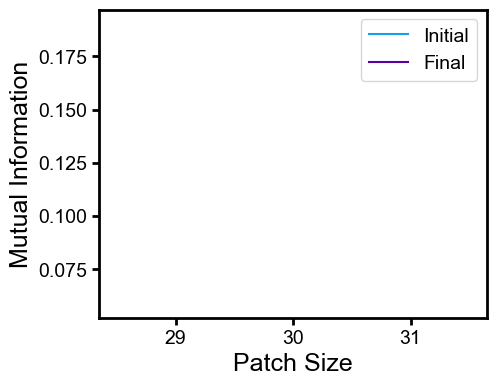

In [7]:
# plot mutual information estimates
print(mi_estimates_initial, mi_estimates_final)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(patch_size_list, mi_estimates_initial, label='Initial')
ax.plot(patch_size_list, mi_estimates_final, label='Final')
ax.set_xlabel('Patch Size')
ax.set_ylabel('Mutual Information')
ax.legend()

Text(0, 0.5, 'Validation Loss')

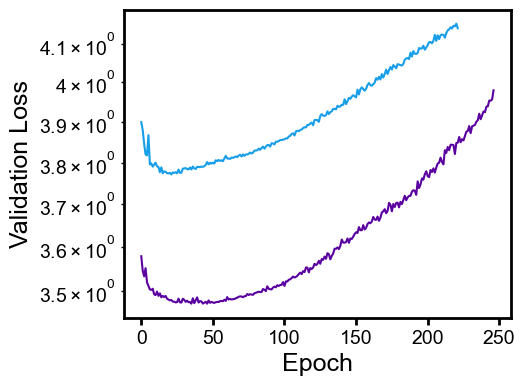

In [12]:
# plot validation loss history for both models
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.semilogy(pixel_cnns_initial[0].val_loss_history[1:], label='Initial')
ax.semilogy(pixel_cnns_final[0].val_loss_history[1:], label='Final')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')

## Generate samples and look at pixel histograms

In [10]:
num_samples = 80

pcnn = pixel_cnns_initial[-1]
samples_initial  = pcnn.generate_samples(num_samples)


pcnn = pixel_cnns_final[-1]
samples_final  = pcnn.generate_samples(num_samples)

Generating PixelCNN samples:   0%|          | 0/30 [00:00<?, ?it/s]2023-12-11 09:32:00.450260: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-12-11 09:32:00.450283: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[80,128,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f64[80,64,30,30]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating PixelCNN samples: 100%|██████████| 30/30 [12:41<00:00, 25.38s/it]


Text(0.5, 1.0, 'Data')

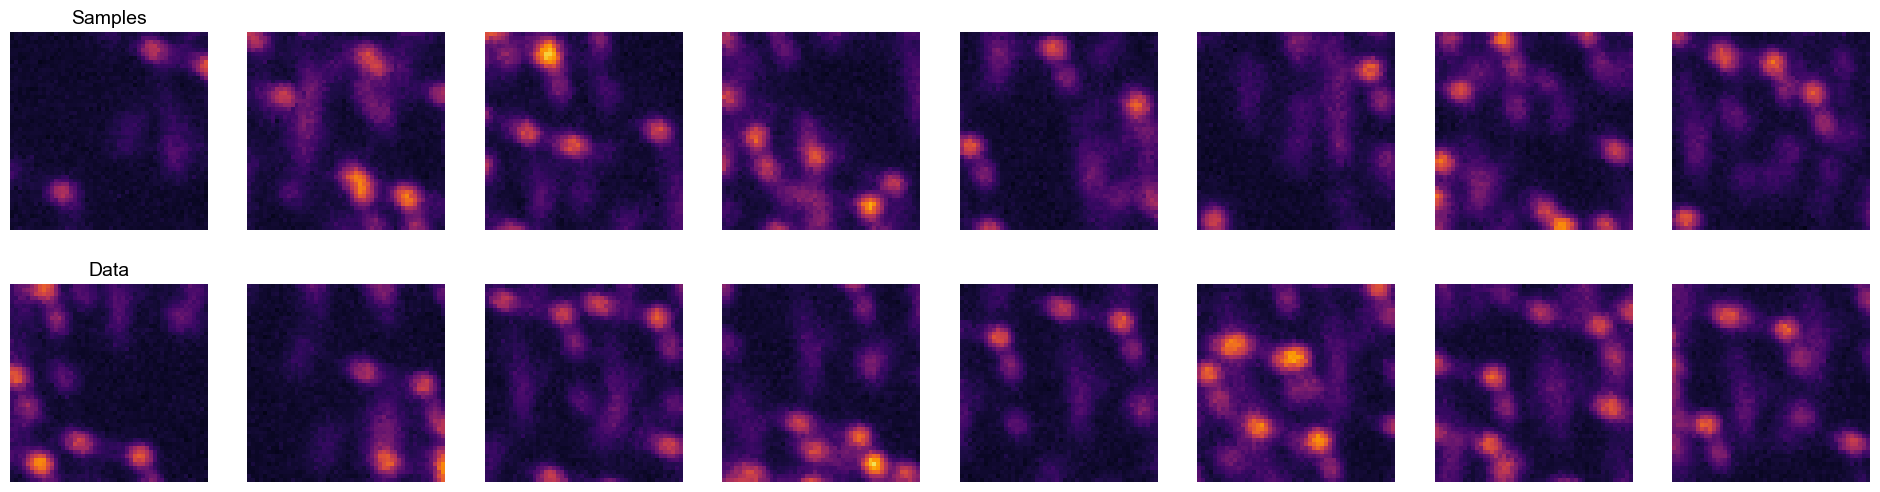

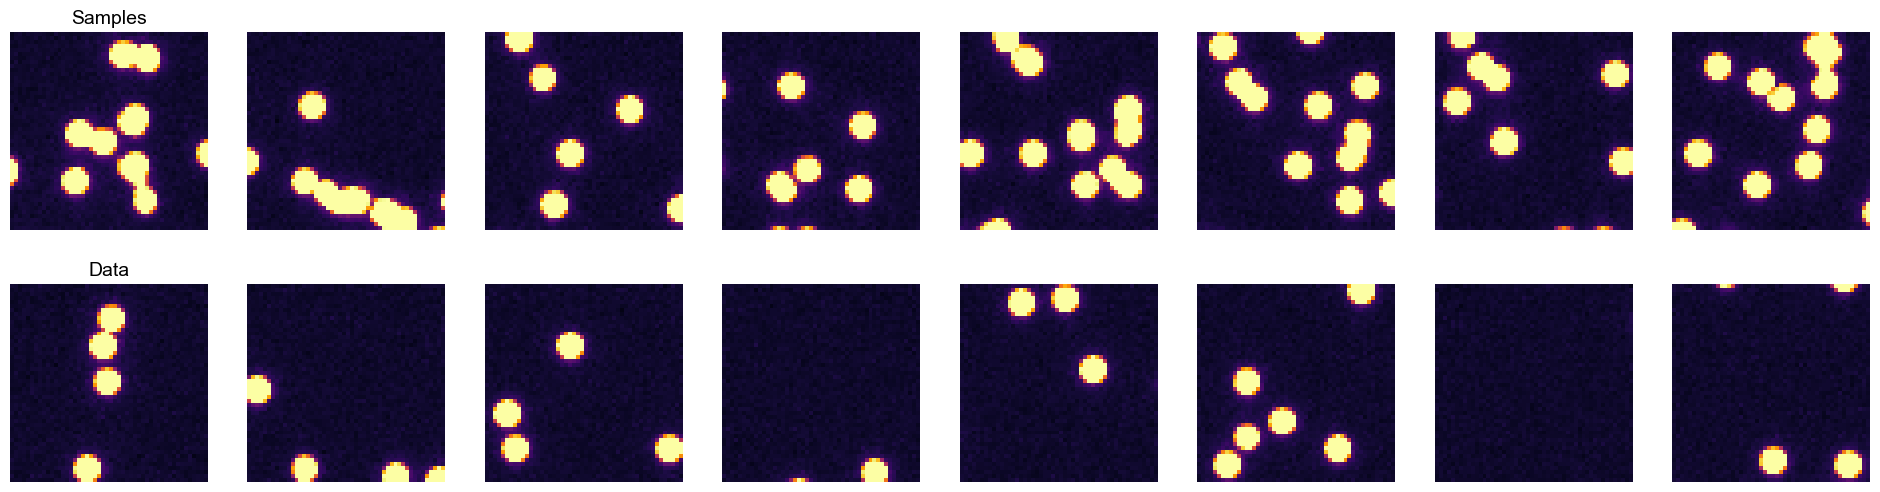

In [56]:
num_samples_to_plot = 8

fig, axes = plt.subplots(2, num_samples_to_plot, figsize=(3 * num_samples_to_plot,6))

vmin, vmax = np.min(np.concatenate([samples_initial, samples_final])), np.percentile(np.concatenate([samples_initial, samples_final]), 95)
# plot real data and samples
for i, ax in enumerate(axes.T):
    ax[0].imshow(samples_initial[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[0].axis('off')
    im = ax[1].imshow(noisy_patches_initial[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[1].axis('off')

# add data and sample labels to first col
axes[0,0].set_title('Samples')
axes[1,0].set_title('Data')


# same thing for final
fig, axes = plt.subplots(2, num_samples_to_plot, figsize=(3 * num_samples_to_plot,6))

vmin, vmax = np.min(np.concatenate([samples_initial, samples_final])), np.percentile(np.concatenate([samples_initial, samples_final]), 95)
# plot real data and samples
for i, ax in enumerate(axes.T):
    ax[0].imshow(samples_final[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[0].axis('off')
    im = ax[1].imshow(noisy_patches_final[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[1].axis('off')

# add data and sample labels to first col
axes[0,0].set_title('Samples')
axes[1,0].set_title('Data')



In [20]:
initial_noisy_data = add_noise(initial_clean_data)
final_noisy_data = add_noise(final_clean_data)

In [27]:
# plot histograms of sampled data and real data

data_pixels_initial = initial_noisy_data.flatten()
sample_pixels_initial = samples_initial.flatten()

# take same number of samples from each
data_pixels_initial = data_pixels_initial[:min(len(data_pixels_initial), len(sample_pixels_initial))]
sample_pixels_initial = sample_pixels_initial[:min(len(data_pixels_initial), len(sample_pixels_initial))]


data_pixels_final = final_noisy_data.flatten()
sample_pixels_final = samples_final.flatten()

# take same number of samples from each
data_pixels_final = data_pixels_final[:min(len(data_pixels_final), len(sample_pixels_final))]
sample_pixels_final = sample_pixels_final[:min(len(data_pixels_final), len(sample_pixels_final))]


In [58]:

bins = np.linspace(min(data_pixels_final.min(), sample_pixels_final.min()), max(data_pixels_final.max(), sample_pixels_final.max()), 100)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(data_pixels_initial,  alpha=0.5, label='Data', bins=bins, density=True, log=True)
ax.hist(sample_pixels_initial,  alpha=0.5, label='Samples', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
ax.title.set_text('Initial')
clear_spines(ax)


fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(data_pixels_final,  alpha=0.5, label='Data', bins=bins, density=True, log=True)
ax.hist(sample_pixels_final,  alpha=0.5, label='Samples', bins=bins, density=True, log=True)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.title.set_text('Final')
ax.legend()
clear_spines(ax)


### Zoom in on low end

In [37]:
small_data_pixels_initial = data_pixels_initial[:num_images]
print(np.min(small_data_pixels_initial), small_data_threshold)

53.0 30.0


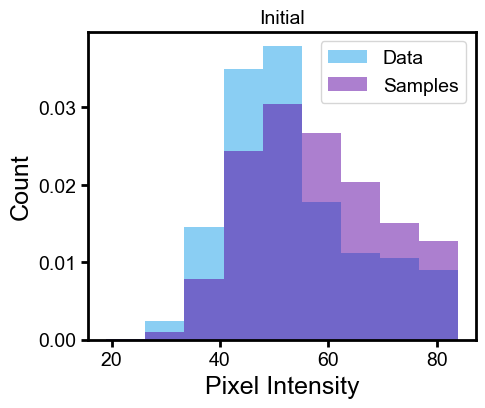

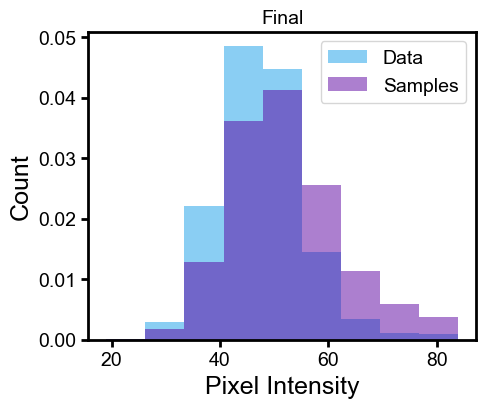

In [44]:
num_images = 10000

small_data_pixels_initial = data_pixels_initial[:num_images]
small_data_threshold = small_data_pixels_initial.min() + 60

small_data_pixels_initial = small_data_pixels_initial[small_data_pixels_initial < small_data_threshold]

small_sample_pixels_initial = sample_pixels_initial[:num_images]
small_sample_pixels_initial = small_sample_pixels_initial[small_sample_pixels_initial < small_data_threshold]

bins = np.linspace(data_pixels_initial.min()-1, small_data_threshold, 10)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(small_data_pixels_initial,  alpha=0.5, label='Data', bins=bins, density=True, log=False)
ax.hist(small_sample_pixels_initial,  alpha=0.5, label='Samples', bins=bins, density=True, log=False)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
ax.title.set_text('Initial')

# same thing for final
small_data_pixels_final = data_pixels_final[:num_images]
small_data_threshold = small_data_pixels_final.min() + 60

small_data_pixels_final = small_data_pixels_final[small_data_pixels_final < small_data_threshold]

small_sample_pixels_final = sample_pixels_final[:num_images]
small_sample_pixels_final = small_sample_pixels_final[small_sample_pixels_final < small_data_threshold]

bins = np.linspace(data_pixels_final.min()-1, small_data_threshold, 10)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(small_data_pixels_final,  alpha=0.5, label='Data', bins=bins, density=True, log=False)
ax.hist(small_sample_pixels_final,  alpha=0.5, label='Samples', bins=bins, density=True, log=False)
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Count')
ax.legend()
ax.title.set_text('Final')